<a href="https://colab.research.google.com/github/lfarlima/Project-2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and Dependencies 

In [19]:
# Install Yahoo Finance API
# !pip install yfinance ## use to run on Colab

In [1]:
# imports and dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer
from datetime import datetime, date, time, timezone
import yfinance as yf
import seaborn as sns
from numpy.random import seed
seed (1)
from tensorflow import random
random.set_seed(2)


## NLTK Imports
from nltk.corpus import stopwords, reuters
from wordcloud import WordCloud, STOPWORDS

# Code to download corpora
import nltk
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

 # Import Keras modules for model creation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

[nltk_data] Downloading package wordnet to /Users/lauren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /Users/lauren/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lauren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lauren/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## VADER sentiment analysis 

In [32]:
# Pull and clean PLTR Twitter sentiment data
pltr_twitter_sentiment_df = pd.read_csv('pltr_twitter_sentiment_df.csv', parse_dates=True, infer_datetime_format=True)
pltr_twitter_sentiment_df.drop_duplicates(inplace=True)
pltr_twitter_sentiment_df.tail()

,date,text,compound,positive,negative,neutral,Polarity Score
441521,2021-04-03 23:46:50 UTC,Watchlist: 1. $NNOX 2. $SOS 3. $BAC 4. $PLTR ...,0.5374,0.108,0.0,0.892,1
441524,2021-04-03 23:48:55 UTC,$PLTR could get a boost with $FB leaking user ...,0.4019,0.213,0.0,0.787,1
441527,2021-04-03 23:55:58 UTC,@thetradingchick Didn’t know you were in $PLTR...,0.6049,0.183,0.0,0.817,1
441530,2021-04-03 23:57:57 UTC,@GeniusStocks @alexcutler247 @gurgavin @SpacBo...,0.2732,0.080,0.0,0.920,1
441533,2021-04-03 23:59:27 UTC,"$PLTR Bullish count leading into Demo day, bea...",0.5994,0.196,0.0,0.804,1


In [33]:
# Sort data, set index ('Date') as DateTime format
pltr_twitter_sentiment_df=pltr_twitter_sentiment_df.sort_values('date')
pltr_twitter_sentiment_df['date'] = pd.to_datetime(pltr_twitter_sentiment_df['date']).dt.date
pltr_twitter_sentiment_df.set_index('date',inplace=True)
pltr_twitter_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136203 entries, 2020-09-29 to 2021-04-03
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   text            136203 non-null  object 
 1   compound        136203 non-null  float64
 2   positive        136203 non-null  float64
 3   negative        136203 non-null  float64
 4   neutral         136203 non-null  float64
 5   Polarity Score  136203 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.3+ MB


In [4]:
#C Calcu
twitter_sent_avg = pltr_twitter_sentiment_df.groupby('date', as_index=True, sort=True)['compound','positive','negative','neutral','Polarity Score'].mean()
twitter_sent_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 2020-09-29 to 2021-04-03
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   compound        187 non-null    float64
 1   positive        187 non-null    float64
 2   negative        187 non-null    float64
 3   neutral         187 non-null    float64
 4   Polarity Score  187 non-null    float64
dtypes: float64(5)
memory usage: 8.8+ KB
<ipython-input-4-82636f05a5a2>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  twitter_sent_avg = pltr_twitter_sentiment_df.groupby('date', as_index=True, sort=True)['compound','positive','negative','neutral','Polarity Score'].mean()


<AxesSubplot:title={'center':'Twitter Sentiments'}, xlabel='Polarity Score'>

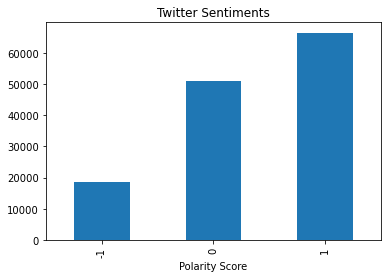

In [39]:
# Graph tallied Polarity Score 
pltr_twitter_sentiment_df.groupby('Polarity Score').size().plot(kind='bar', title='Twitter Sentiments')

In [36]:
 # Pull data from Newsapi
pltr_newsapi_df = pd.read_csv('Newsapi.csv')
pltr_newsapi_df.head()

,Unnamed: 0,source,author,title,description,url,urlToImage,publishedAt,content
0,0,"{'id': None, 'name': 'Benzinga'}",Tyler Bundy,Palantir Stock Trades Higher: A Technical Anal...,Palantir Technology Inc. (NYSE:PLTR) shares we...,https://www.benzinga.com/trading-ideas/long-id...,https://cdn2.benzinga.com/files/imagecache/og_...,2021-03-25T19:06:00Z,Palantir Technology Inc. (NYSE:PLTR) shares we...
1,1,"{'id': 'business-insider', 'name': 'Business I...",Emily Graffeo,Palantir jumps after securing 5-year contract ...,Summary List PlacementShares of Palantir gaine...,https://www.businessinsider.com/palantir-stock...,https://i.insider.com/605213680347cb00184b63a3...,2021-04-05T13:16:57Z,Shares of Palantir gained 3.47% early Monday a...
2,2,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Staff,Former Credit Suisse exec backed SPAC to take ...,Sarcos Robotics Inc said on Tuesday it will go...,https://www.reuters.com/article/us-sarcos-m-a-...,https://s1.reutersmedia.net/resources_v2/image...,2021-04-06T10:53:00Z,By Reuters Staff\r\n(Reuters) - Sarcos Robotic...
3,3,"{'id': None, 'name': 'Slashdot.org'}",BeauHD,Coinbase Sets Direct Listing For April 14,"Coinbase, the largest U.S. cryptocurrency exch...",https://slashdot.org/story/21/04/01/2124242/co...,https://a.fsdn.com/sd/topics/bitcoin_64.png,2021-04-02T01:25:00Z,The company's registration statement for the l...
4,4,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Staff,Breakingviews - Capital Calls - Cellebrite goo...,SOMETHING TO CELLEBRITE. Controversy over cops...,https://www.reuters.com/article/us-global-fina...,https://static.reuters.com/resources/r/?m=02&d...,2021-04-08T19:41:00Z,By Reuters Staff\r\nA Cellebrite forensic devi...


In [37]:
# Function to calculate sentiment based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1
    return result

In [38]:
# # Create empty list for news sentiments
pltr_sentiments = []

# # Iterate through rows to analyze tweets 
for index, row in pltr_newsapi_df.iterrows():
    try:
        text = row["content"]
        date = row["publishedAt"]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        pol=  get_sentiment(compound)
        
        pltr_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu,
            "Polarity Score":pol
            
        })
        
    except AttributeError:
        pass

In [9]:
# Create DataFrame
pltr_newsapi_sentiment_df = pd.DataFrame(pltr_sentiments)

# Reorder DataFrame columns, set index ('date') as DateTime format
pltr_newsapi_sentiment_df=pltr_newsapi_sentiment_df.sort_values('date')
pltr_newsapi_sentiment_df['date'] = pd.to_datetime(pltr_newsapi_sentiment_df['date']).dt.date
pltr_newsapi_sentiment_df.set_index('date',inplace=True)
pltr_newsapi_sentiment_df.head()

,text,compound,positive,negative,neutral,Polarity Score
date,,,,,,
2021-03-10,As we move into the vaccination phase of the C...,0.4939,0.135,0.000,0.865,1
2021-03-10,"In this video, I will talk about the five stoc...",0.7003,0.167,0.000,0.833,1
2021-03-10,Overview\r\n After an unprecedented rally in h...,0.0000,0.000,0.000,1.000,0
2021-03-10,Net Asset Value of $15.14 per Share as of Dece...,0.8934,0.305,0.000,0.695,1
2021-03-11,Image source: The Motley Fool.\r\nSuRo Capital...,-0.4404,0.000,0.108,0.892,-1


In [10]:
### Calculate sentiment average by date
newsapi_sent_avg = pltr_newsapi_sentiment_df.groupby('date', as_index=True, sort=True)[['compound','positive','negative','neutral','Polarity Score']].mean()
newsapi_sent_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 2021-03-10 to 2021-04-10
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   compound        29 non-null     float64
 1   positive        29 non-null     float64
 2   negative        29 non-null     float64
 3   neutral         29 non-null     float64
 4   Polarity Score  29 non-null     float64
dtypes: float64(5)
memory usage: 1.4+ KB


<AxesSubplot:title={'center':'News Sentiments'}, xlabel='Polarity Score'>

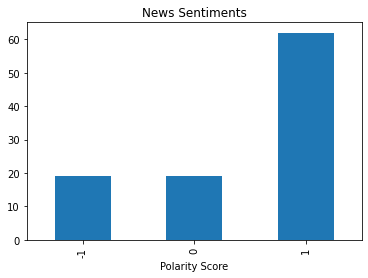

In [41]:
# Graph tallied Polarity Score 
pltr_newsapi_sentiment_df.groupby('Polarity Score').size().plot(kind='bar', title='News Sentiments')

## Yahoo Finance Stock API 

In [49]:
# Load PLTR stock closing prices from YFinance
pltr_yf = yf.download('PLTR',
                       start='2020-01-01',
                       end='2021-05-31',
                       progress=False,
                       infer_datetime_format= True,
                       parse_dates = True,
                       interval='1d'

)
# Create DataFrame
pltr_yf_df = pd.DataFrame(pltr_yf)
# Reorder DataFrame columns
pltr_yf_df=pltr_yf_df.sort_values('Date')
pltr_yf_df.drop(columns=['Open','High','Low','Volume','Adj Close'],inplace=True)
pltr_yf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2020-09-30 to 2021-04-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [55]:
## Combine News scores with PLTR close prices
pltr_yf_newsapi = pd.concat([pltr_yf_df,newsapi_sent_avg],axis=1,join='outer')
pltr_yf_newsapi.dropna(inplace=True)
pltr_yf_newsapi.head()

,Close,compound,positive,negative,neutral,Polarity Score
2021-03-10,24.750000,0.521900,0.15175,0.000000,0.848250,0.750000
2021-03-11,26.730000,-0.071825,0.01925,0.042000,0.938750,0.000000
2021-03-12,26.920000,0.000000,0.00000,0.000000,1.000000,0.000000
2021-03-15,26.790001,0.054700,0.06800,0.057667,0.874333,0.333333
2021-03-16,25.610001,0.513567,0.14500,0.020000,0.835000,1.000000


In [56]:
## Combine Twitter scores with PLTR close prices
pltr_yf_twitter = pd.concat([pltr_yf_df,twitter_sent_avg],axis=1,join='outer')
pltr_yf_twitter.dropna(inplace=True)
pltr_yf_twitter.drop(columns=['positive','negative','neutral','Polarity Score'])
pltr_yf_twitter.head()

,Close,compound,positive,negative,neutral,Polarity Score
2020-09-30,9.50,0.147594,0.094543,0.034711,0.870748,0.272287
2020-10-01,9.46,0.009902,0.080625,0.063405,0.855963,0.101329
2020-10-02,9.20,-0.000485,0.084356,0.061115,0.854532,0.108974
2020-10-05,9.03,0.186457,0.091758,0.033205,0.875005,0.394737
2020-10-06,9.90,0.197717,0.104604,0.036160,0.859233,0.363144


<AxesSubplot:>

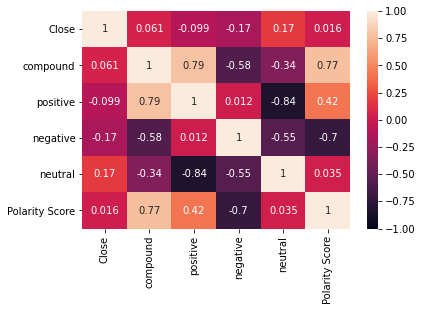

In [57]:
# # Calculate correlation of News scores to Closing price
newsapi_yf_corr = pltr_yf_newsapi.corr()
sns.heatmap(newsapi_yf_corr,vmin=-1,vmax=1,annot=True)

<AxesSubplot:>

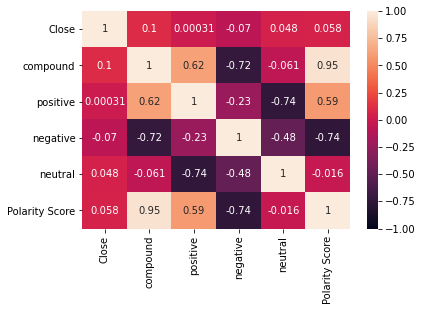

In [58]:
# Calculate correlation of Twitter scores to Closing price
twitter_yf_corr = pltr_yf_twitter.corr()
sns.heatmap(twitter_yf_corr,vmin=-1,vmax=1,annot=True)

In [60]:
pltr_yf_twitter.head()

,Close,compound,positive,negative,neutral,Polarity Score,Rolling 5 Day Compound
2020-09-30,9.50,0.147594,0.094543,0.034711,0.870748,0.272287,NaN
2020-10-01,9.46,0.009902,0.080625,0.063405,0.855963,0.101329,NaN
2020-10-02,9.20,-0.000485,0.084356,0.061115,0.854532,0.108974,NaN
2020-10-05,9.03,0.186457,0.091758,0.033205,0.875005,0.394737,NaN
2020-10-06,9.90,0.197717,0.104604,0.036160,0.859233,0.363144,0.108237


<AxesSubplot:>

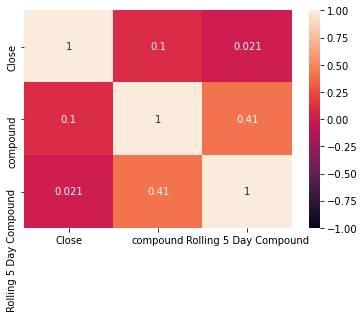

In [61]:
# Calculate 5-Day Rolling Average 
twitter_rolling_compound = pltr_yf_twitter["compound"].rolling(5).mean()
pltr_yf_twitter['Rolling 5 Day Compound'] = twitter_rolling_compound # add new column with rolling average data

newsapi_rolling_compound = pltr_yf_newsapi["compound"].rolling(5).mean()
pltr_yf_newsapi['Rolling 5 Day Compound'] = newsapi_rolling_compound # add new column with rolling average data

twitter_yf_corrs = pltr_yf_twitter[['Close','compound','Rolling 5 Day Compound']].corr()
sns.heatmap(twitter_yf_corrs,vmin=-1,vmax=1,annot=True)

# This heatmap shows the Twitter compound score is the most correlated to the closing price. The correlation is very weak, likely insignificant. 



<AxesSubplot:>

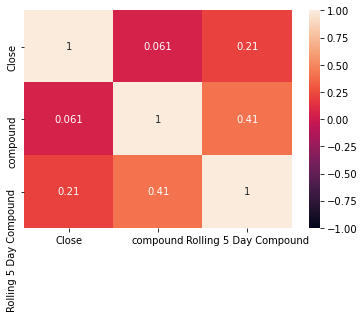

In [62]:
newsapi_yf_corrs = pltr_yf_newsapi[['Close','compound','Rolling 5 Day Compound']].corr()
sns.heatmap(newsapi_yf_corrs,vmin=-1,vmax=1,annot=True)

# This heatmap shows the News rolling 5-day compound sentiments scores is more correlated to the closing price. This correlation is weak and not likely to be significant. 

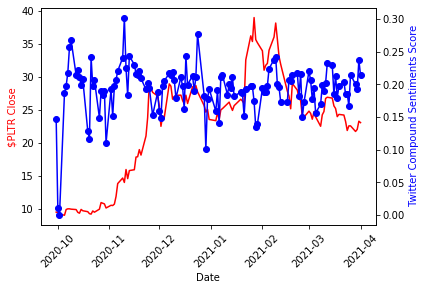

In [67]:
# PLOT THE CLOSING PRICE AND DATE
fig, ax =plt.subplots()
ax.plot(pltr_yf_twitter.index, pltr_yf_twitter.Close, color="red")
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("$PLTR Close", color='red')

# PLOT THE COMPOUND SENTIMENT SCORES
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pltr_yf_twitter.index, pltr_yf_twitter["compound"],color="blue",marker="o")
ax2.set_ylabel(" Twitter Compound Sentiments Score",color="blue")
plt.show()

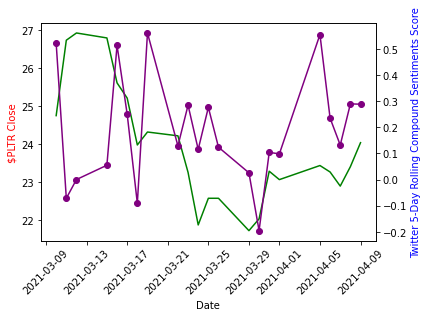

In [70]:
# PLOT THE CLOSING PRICE AND DATE
fig, ax =plt.subplots()
ax.plot(pltr_yf_newsapi.index, pltr_yf_newsapi.Close, color="green")
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("$PLTR Close", color='red')

# PLOT THE COMPOUND SENTIMENT SCORES
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pltr_yf_newsapi.index, pltr_yf_newsapi["compound"], color="purple", marker="o") 
ax2.set_ylabel("Twitter 5-Day Rolling Compound Sentiments Score",color="blue")
plt.show()

## PLOT THE ROLLING COMPOUND SENTIMENT SCORES
ax2.plot(pltr_yf_newsapi.index, newsapi_rolling_compound, color="orange", marker="o") 
ax2.set_ylabel("Twitter 5 Day Rolling Compound Sentiments Score",color="blue")
plt.show()

## VADER Sentiments WordCloud 

In [71]:
# Twitter WordCloud
words = ' '.join(pltr_twitter_sentiment_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
stopwords = set(STOPWORDS)
stopwords.add("PLTR")
stopwords.add("Palantir")

twitter_wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

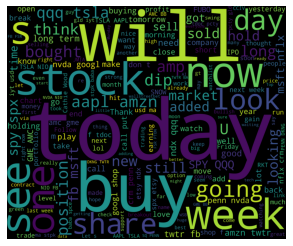

In [72]:
plt.figure(1,figsize=(5, 5))
plt.imshow(twitter_wordcloud)
plt.axis('off')
plt.show()

In [74]:
#. NewsApi WordCloud
df = pltr_newsapi_sentiment_df["Polarity Score"]  ## WHAT IS THIS LINE FOR???
#pltr_twitter_sentiment_df[pltr_twitter_sentiment_df["Polarity Score"]=='-1']
words = ' '.join(pltr_newsapi_sentiment_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
stopwords = set(STOPWORDS)
stopwords.add("PLTR")
stopwords.add("Palantir")

newsapi_wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

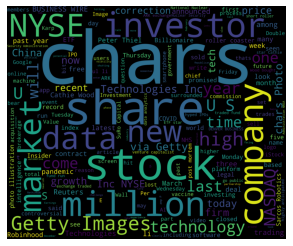

In [75]:
plt.figure(1,figsize=(5, 5))
plt.imshow(newsapi_wordcloud)
plt.axis('off')
plt.show()

## LSTM Model 

In [117]:
# Data Preprocessing for Twitter df 
pltr_yf_twitter["Close 5D Avg"]= pltr_yf_twitter["Close"].rolling(5).mean()
pltr_yf_twitter['Compound 5D Avg'] = pltr_yf_twitter["compound"].rolling(5).mean()

# Creating multivariate X and y vectors for Twitter and Newsapi
X = pltr_yf_twitter[["Close 5D Avg",'Compound 5D Avg']].values
y = pltr_yf_twitter[['Close','Close']].values

print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")
print(y.shape)
print(X.shape)

X sample values:
[[       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [9.41799984 0.10823729]
 [9.51799984 0.12222618]
 [9.62599983 0.1716009 ]
 [9.77599983 0.22514236]
 [9.94799995 0.23071356]
 [9.86200008 0.23562829]] 

y sample values:
[[ 9.5         9.5       ]
 [ 9.46000004  9.46000004]
 [ 9.19999981  9.19999981]
 [ 9.02999973  9.02999973]
 [ 9.89999962  9.89999962]
 [10.         10.        ]
 [10.         10.        ]
 [ 9.94999981  9.94999981]
 [ 9.89000034  9.89000034]
 [ 9.47000027  9.47000027]]
(127, 2)
(127, 2)


In [118]:
# Creating training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(71, 2)
(71, 2)
(32, 2)
(32, 2)


In [119]:
# Normalize the data using MinMaxScaler function to increase model accuracy
scaler = MinMaxScaler() 
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit_transform(y_train)
scaler.fit_transform(y_test)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [120]:
print (f"X_train sample values:\n{X_train[:10]} \n")
print (f"y_train sample values:\n{y_train[:10]}")
print (f"X_test sample values:\n{X_test[:10]} \n")
print (f"y_test sample values:\n{y_test[:10]}")

X_train sample values:
[[ 0.56763323  0.24018734]
 [ 0.63283742  0.57336505]
 [ 0.0043267   0.38147204]
 [ 0.82139064  0.33118471]
 [ 1.01723091  0.03964706]
 [ 0.56839229 -0.04082449]
 [ 0.56269926  0.34260213]
 [ 0.97608925  0.74388403]
 [ 0.61932596  0.36532427]
 [ 0.65189009  0.18741196]] 

y_train sample values:
[[0.60510876 0.60510876]
 [0.56644811 0.56644811]
 [0.01277183 0.01277183]
 [0.61719024 0.61719024]
 [0.89678985 0.89678985]
 [0.48912675 0.48912675]
 [0.50914746 0.50914746]
 [0.91473947 0.91473947]
 [0.59164658 0.59164658]
 [0.5685192  0.5685192 ]]
X_test sample values:
[[0.6572795  0.44804629]
 [0.00280856 0.09418177]
 [0.         0.17298919]
 [0.03461363 0.24766031]
 [0.02649157 0.26817357]
 [0.94618186 0.71116811]
 [1.         0.02849556]
 [0.4903598  0.33944218]
 [0.74146047 0.34681453]
 [       nan        nan]] 

y_test sample values:
[[0.62236799 0.62236799]
 [0.00241632 0.00241632]
 [0.01656888 0.01656888]
 [0.05350363 0.05350363]
 [0.05695549 0.05695549]
 [1.    

In [121]:
 # Define the LSTM RNN model
model = Sequential()
units = 24
dropout_fraction = 0.2
X_train = np.expand_dims(X_train,2)
y_train = np.expand_dims(y_train,2)

# Layer 1
model.add(LSTM(
    units = units,
    input_shape=(X_train.shape[1:]),
    return_sequences=True,
    activation='relu'
))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=units,input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=units, input_shape=(X_train.shape[1:]),return_sequences=False))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(2,activation='sigmoid'))

In [122]:
# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer="adam"
)

In [114]:
 # Summarize the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 2, 24)             2496      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 24)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 2, 24)             4704      
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 24)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dropout_11 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [116]:
# Training the model

model.fit(X_train,
    y_train,
    epochs=5, 
    shuffle=False)

Epoch 1/10
3/3 [==============================] - 3s 3ms/step - loss: nan
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: nan
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: nan
Epoch 6/10
3/3 [==============================] - 0s 3ms/step - loss: nan
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: nan
Epoch 8/10
3/3 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/10
3/3 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/10
3/3 [==============================] - 0s 4ms/step - loss: nan


In [212]:
# # Evaluate the model
X_val = np.expand_dims(X_val,1)
y_val = np.expand_dims(y_val,1)
scaler.fit_transform(X_val)
scaler.fit_transform(y_val)

X_val = X_val.reshape(2,-1)
y_val = y_val.reshape(2,-1)
model.evaluate(X_val,y_val)

ValueError: Found array with dim 4. MinMaxScaler expected <= 2.